In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

## Data preprocessing

In [2]:
df_for_learning = pd.read_csv("train.csv")
df_for_test = pd.read_csv("test.csv")
df_test_id = df_for_test["Id"]

In [3]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [4]:
df_for_learning = clean(df_for_learning)
df_for_test = clean(df_for_test)

In [5]:
df_for_learning.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_for_learning.shape

(1460, 81)

Analysis of the missing data

In [7]:
data_miss_values_sum = df_for_learning.isna().sum().sort_values(ascending=False)
data_miss_values_mean = df_for_learning.isna().mean().sort_values(ascending=True)
miss_values_summary = pd.concat([data_miss_values_sum,data_miss_values_mean], axis=1, keys=['Total', 'Percentage'])
miss_values_summary.head(20)

,Total,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [8]:
# choose features with most numbers of missing values
# take a look at them
columns_with_many_missings_number = 5
percentage_threshhold = 0.15
columns_with_many_missings = list(miss_values_summary[miss_values_summary['Percentage']>percentage_threshhold].index)
columns_with_many_missings

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

In [9]:
for column in columns_with_many_missings:
    print(f'Feature {column}')
    display(df_for_learning[column].value_counts(dropna=False))

Feature PoolQC


NaN    1453
Gd        3
Fa        2
Ex        2
Name: PoolQC, dtype: int64

Feature MiscFeature


NaN     1406
Shed      49
Othr       2
Gar2       2
TenC       1
Name: MiscFeature, dtype: int64

Feature Alley


NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

Feature Fence


NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

Feature FireplaceQu


NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

Feature LotFrontage


NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
111.0      1
141.0      1
112.0      1
152.0      1
144.0      1
Name: LotFrontage, Length: 111, dtype: int64

In [10]:
def get_num_features_for_train(df):
    numerical_features = list(df.select_dtypes(include=['int64','float64']).columns)
    if 'SalePrice' in numerical_features:
        numerical_features.remove('SalePrice')
    return numerical_features

In [11]:
# function for replacing NaNs with means and modes 
# (depends on dtype of variable)
def remove_nans_custom(df):
    obj_features = list(df.select_dtypes(include=['object']).columns)
    int_features = list(df.select_dtypes(include=['int64']).columns)
    float_features = list(df.select_dtypes(include=['float64']).columns)
    # int_features = get_num_features_for_train(df)
#     df[int_features] = df[int_features].apply(lambda x: x.fillna(x.interpolate(method='spline',order = 3)))
    df[int_features] = df[int_features].apply(lambda x: x.fillna(x.fillna(x.median())))
    df[float_features] = df[float_features].apply(lambda x: x.fillna(x.fillna(x.mean())))
    df[obj_features] = df[obj_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df

Remove all columns with too many NaNs and replace in remaining ones NaN with means and modes

In [12]:
df_for_learning_no_missing = df_for_learning.drop(columns = columns_with_many_missings)
df_for_test_no_missing = df_for_test.drop(columns = columns_with_many_missings)
#df_for_learning_no_missing = remove_nans_custom(df_for_learning_no_missing)
#df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)


Let's remove all features which are almost constant (consist more than 95% of a certain value)

In [13]:
def get_almost_constant_columns(df, type_of_columns, threshold = 0.95):
    almost_constant_column = [feature for feature in df.select_dtypes(include = type_of_columns).columns
                 if df[feature].value_counts(normalize=True).values[0] > threshold]
    return almost_constant_column

In [14]:
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    threshold = 0.95
    homogenity_rate = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if homogenity_rate > threshold:
        print("feature: {}, homogenity rate: {} ".format(feature, homogenity_rate))
        print(df_for_learning_no_missing[feature].value_counts())

feature: Street, homogenity rate: 0.9958904109589041 
Pave    1454
Grvl       6
Name: Street, dtype: int64
feature: Utilities, homogenity rate: 0.9993150684931507 
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
feature: Condition2, homogenity rate: 0.9897260273972602 
Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64
feature: RoofMatl, homogenity rate: 0.9821917808219178 
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Roll          1
Membran       1
ClyTile       1
Name: RoofMatl, dtype: int64
feature: Heating, homogenity rate: 0.9780821917808219 
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
feature: GarageQual, homogenity rate: 0.9506889050036258 
TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64
feature: GarageCond, homogenity rate: 0.961

In [15]:
# # remove all columns which consist on 95%+ of the same value
almost_constant_column = get_almost_constant_columns(df_for_learning_no_missing,['object'], threshold=0.95)
almost_constant_column

['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'GarageQual',
 'GarageCond']

In [16]:
df_for_learning_no_missing.drop(columns = almost_constant_column,inplace=True)
df_for_test_no_missing.drop(columns = almost_constant_column,inplace=True)

Analyze categorical features, which values they do contain

In [17]:
thrs_max = 0.95
thrs_min = 0.85
for feature in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    homogenity_rate = df_for_learning_no_missing[feature].value_counts(normalize=True)[0]
    if (homogenity_rate <= thrs_max) and (homogenity_rate > thrs_min):
        print("feature: {}, homogenity rate: {}".format(feature, homogenity_rate))
        print(df_for_learning_no_missing[feature].value_counts())

feature: LandContour, homogenity rate: 0.897945205479452
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
feature: LandSlope, homogenity rate: 0.9465753424657535
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
feature: Condition1, homogenity rate: 0.863013698630137
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
feature: ExterCond, homogenity rate: 0.8780821917808219
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
feature: BsmtCond, homogenity rate: 0.921293042867182
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
feature: BsmtFinType2, homogenity rate: 0.8832630098452883
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
feature: CentralAir, homogenity rate: 0.934931506849315
Y    1365
N      95
Name: Centr

Some of them may be binarized (features consisting between 80 and 95% of the same value)

Function beneath had been made for that purpose 

In [18]:
def binarize_features(df_tr, df_test, type_of_columns, thrs_max = 0.95, thrs_min = 0.85):
    features_to_binarize = []
    for feature in df_tr.select_dtypes(include = type_of_columns).columns:
        homogenity_rate = df_tr[feature].value_counts(normalize=True).values[0]
        if (homogenity_rate <= thrs_max) and (homogenity_rate > thrs_min):
            features_to_binarize.append(feature)
            most_freq_el = df_tr[feature].value_counts().index[0]
            new_feature_name = "{}_is_{}".format(feature, str(most_freq_el))
            df_tr[new_feature_name] = df_tr[feature].apply(lambda x: 1 if x == most_freq_el else 0 )
            df_tr.drop(columns = [feature],inplace=True)
            df_test[new_feature_name] = df_test[feature].apply(lambda x: 1 if x == most_freq_el else 0 )
            df_test.drop(columns = [feature],inplace=True)
    return features_to_binarize

In [19]:
# cols_to_binarize = binarize_features(df_for_learning_no_missing, df_for_test_no_missing, ['object'], thrs_max=0.95, thrs_min =0.85)

Numerical features should be analyzed, maybe they can be binarized

In [20]:
for feature in df_for_learning_no_missing.select_dtypes(include = ['int64','float64']).columns:
    threshold = df_for_learning_no_missing[feature].value_counts(normalize=True).values[0]
    if  (threshold > 0.85):
        print(feature)
        print(df_for_learning_no_missing[feature].value_counts(normalize=True))

BsmtFinSF2
0       0.885616
180     0.003425
374     0.002055
117     0.001370
391     0.001370
          ...   
215     0.000685
211     0.000685
210     0.000685
208     0.000685
1474    0.000685
Name: BsmtFinSF2, Length: 144, dtype: float64
LowQualFinSF
0      0.982192
80     0.002055
360    0.001370
392    0.000685
528    0.000685
515    0.000685
514    0.000685
513    0.000685
481    0.000685
479    0.000685
473    0.000685
420    0.000685
397    0.000685
390    0.000685
53     0.000685
384    0.000685
371    0.000685
234    0.000685
232    0.000685
205    0.000685
156    0.000685
144    0.000685
120    0.000685
572    0.000685
Name: LowQualFinSF, dtype: float64
BsmtHalfBath
0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64
KitchenAbvGr
1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64
EnclosedPorch
0      0.857534
112    0.010274
96     0.004110
120    0.003425
192    0.003425
         ...   
170    0.000685
169 

You see, there are many feaures can be binarized or totally removed

In [21]:
almost_constant_column_int = get_almost_constant_columns(df_for_learning_no_missing,['int64','float64'], threshold = 0.95)
almost_constant_column_int

['LowQualFinSF', 'KitchenAbvGr', 'Threeseasonporch', 'PoolArea', 'MiscVal']

In [22]:
df_for_learning_no_missing.drop(columns = almost_constant_column_int, inplace = True)
df_for_test_no_missing.drop(columns = almost_constant_column_int, inplace = True)

Binarize all numerical feauters with a value's dominance

In [23]:
#binarize_features(df_for_learning_no_missing, df_for_test_no_missing, ['int64','float64'])

Let's take a look how SalePrice depends on other columns

Categorical features:

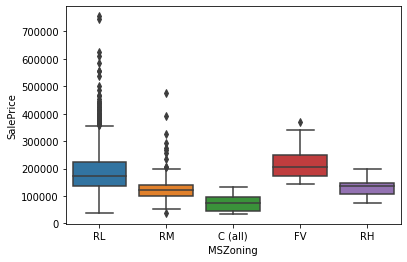

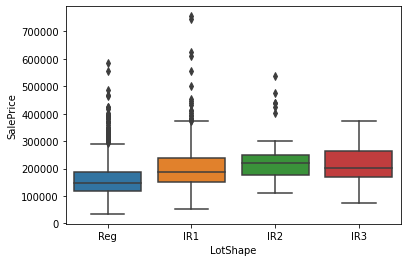

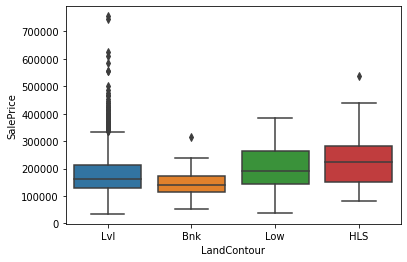

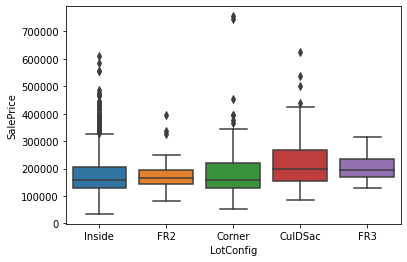

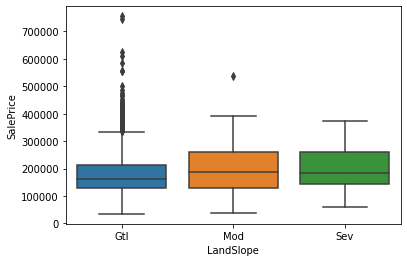

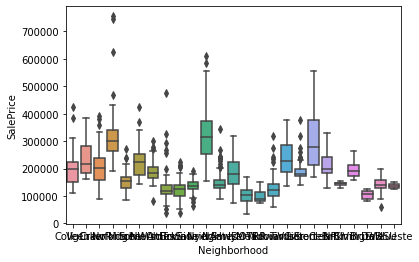

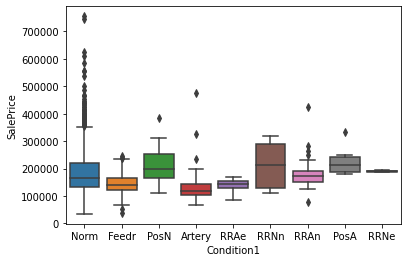

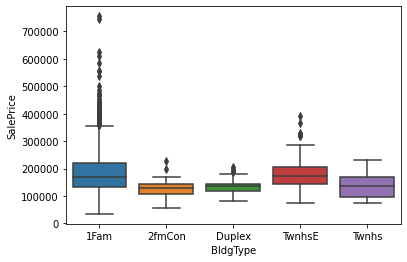

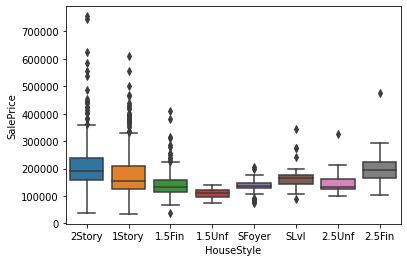

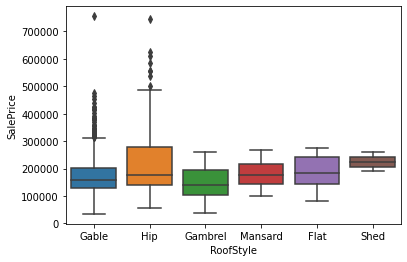

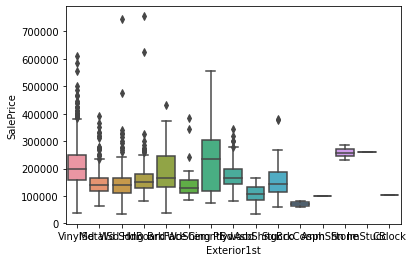

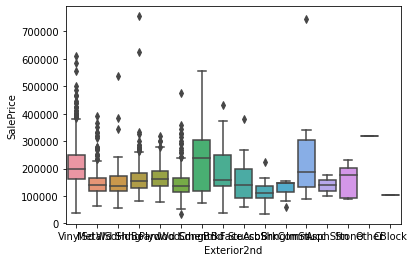

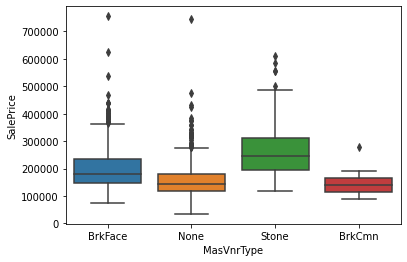

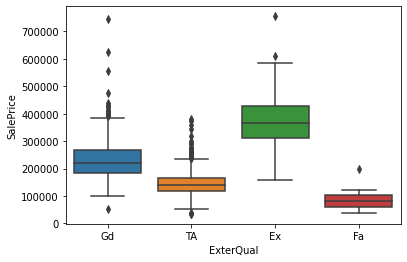

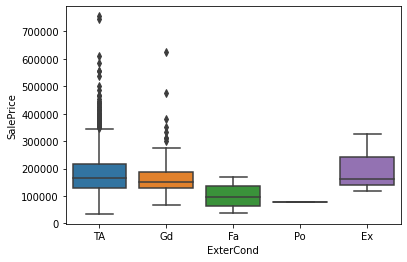

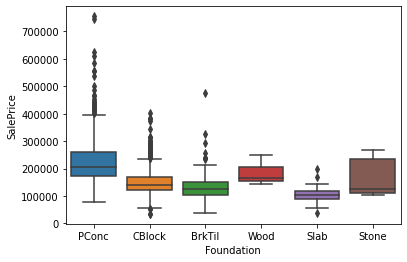

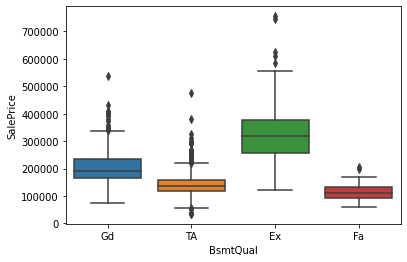

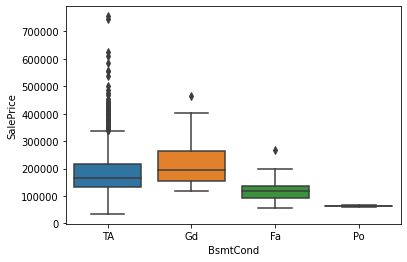

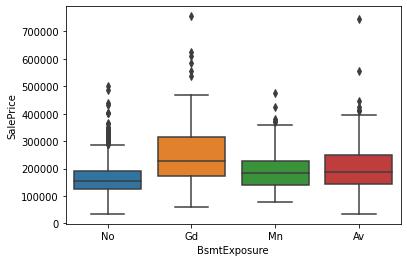

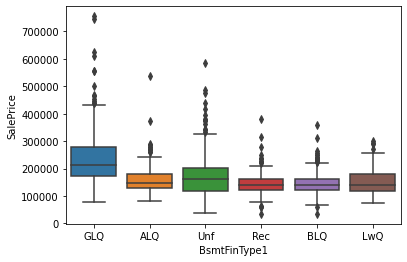

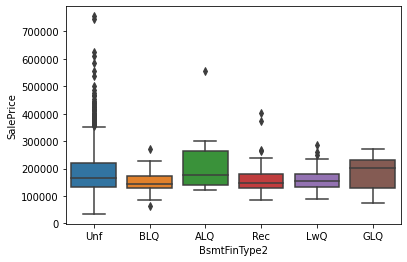

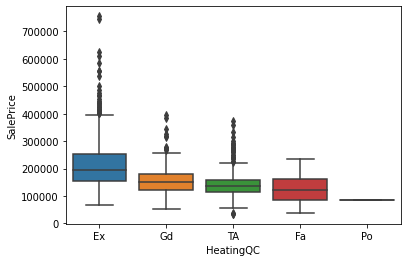

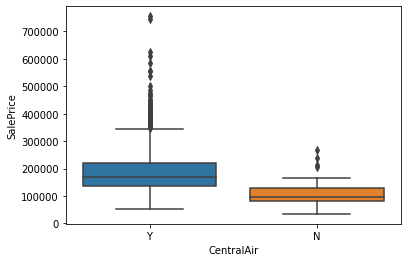

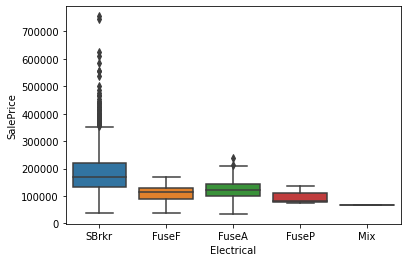

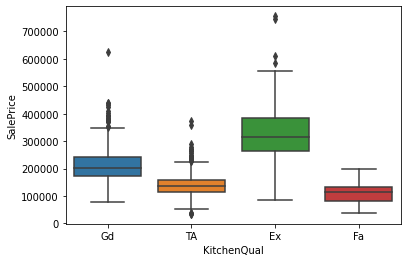

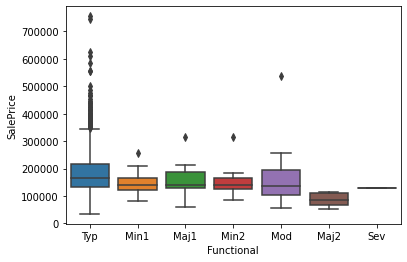

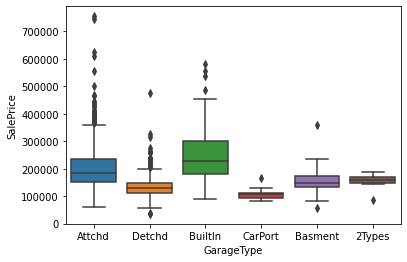

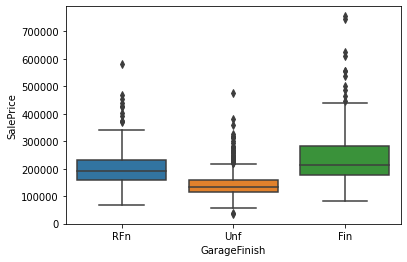

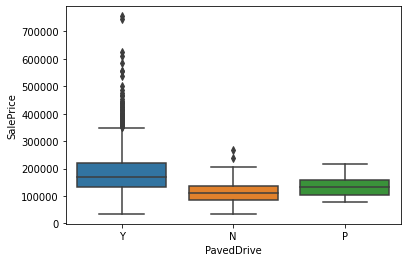

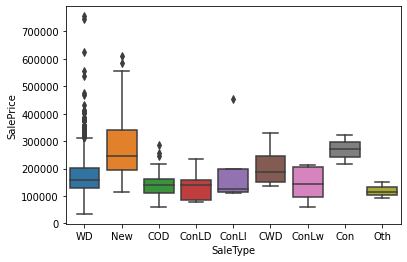

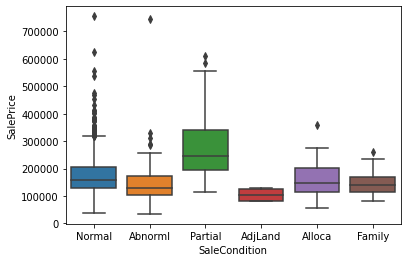

In [24]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['object']).columns:
    sns.boxplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'], data=df_for_learning)
    plt.show()

Numerical features:

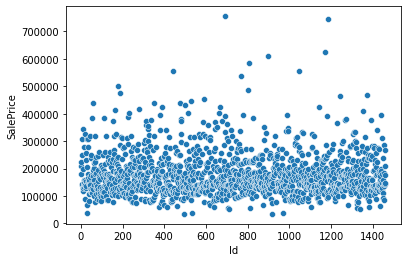

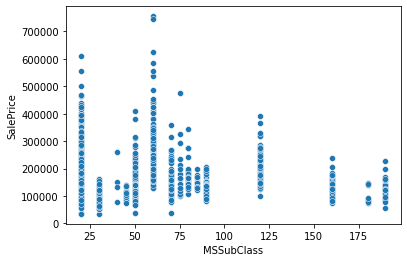

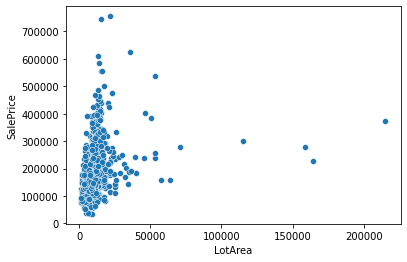

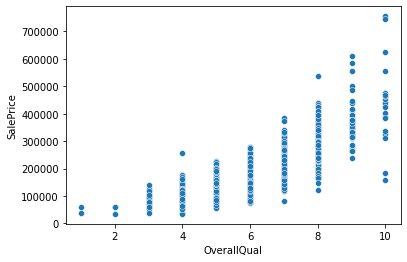

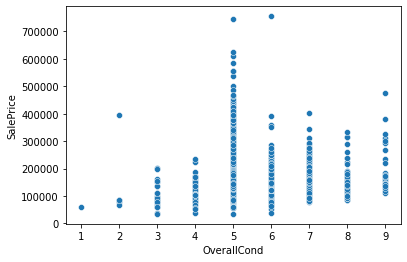

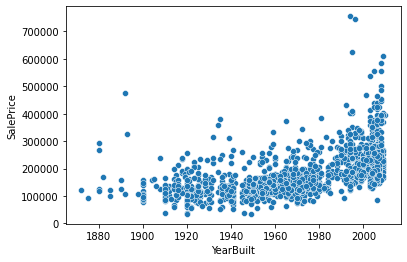

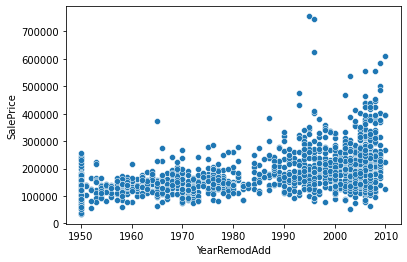

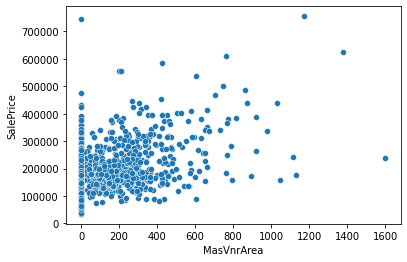

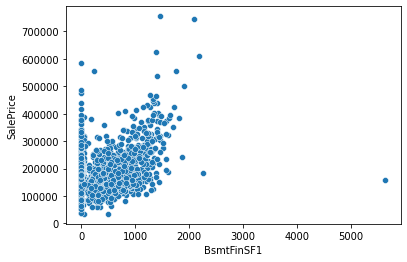

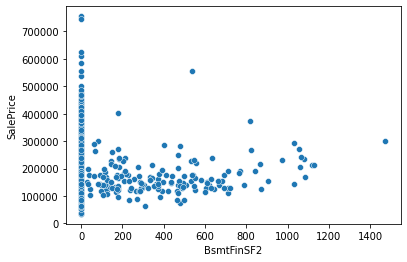

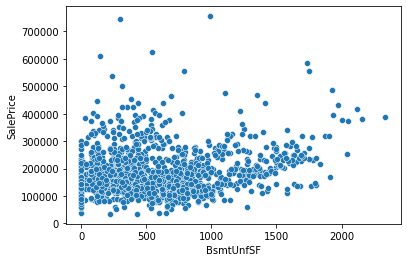

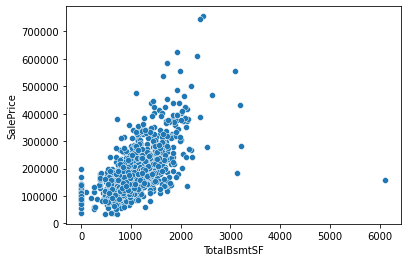

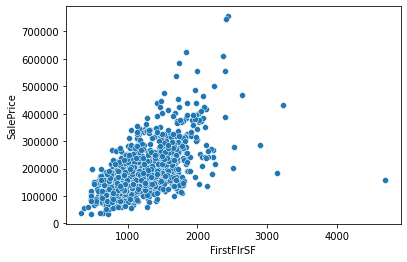

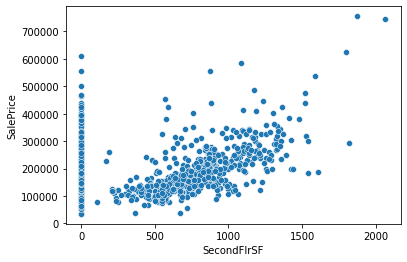

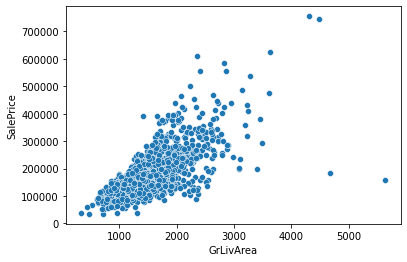

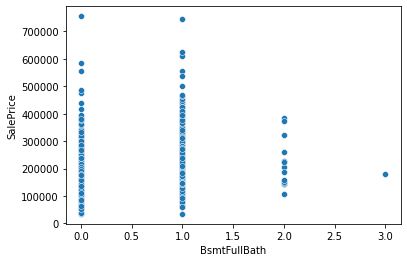

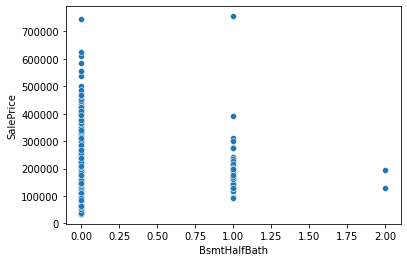

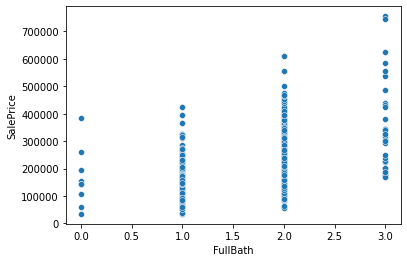

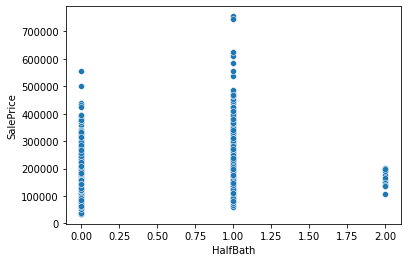

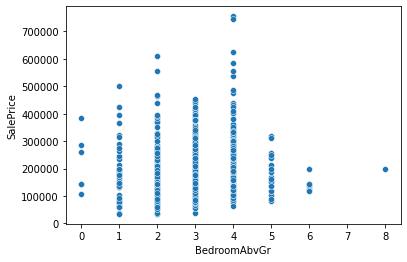

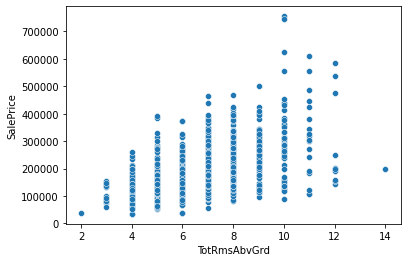

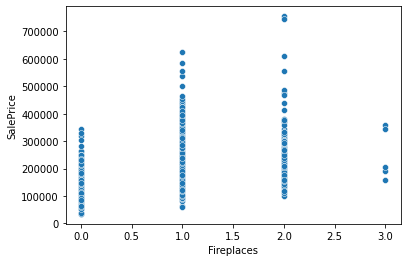

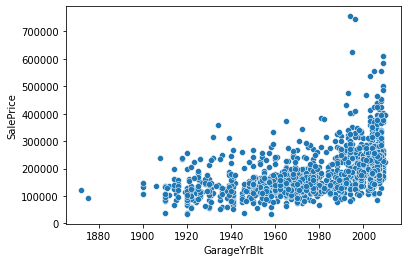

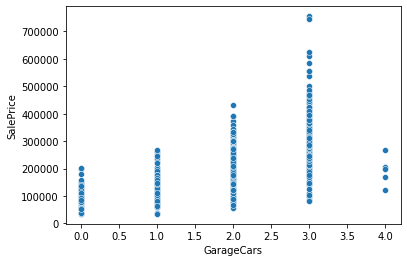

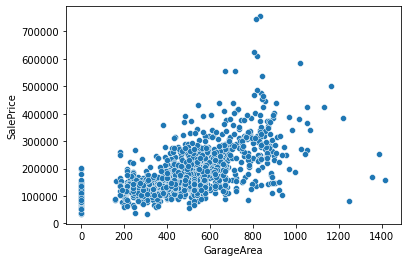

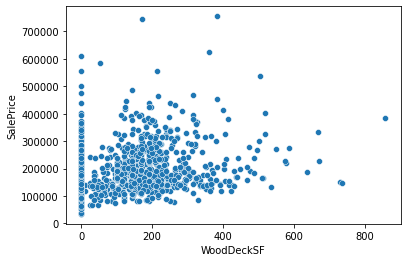

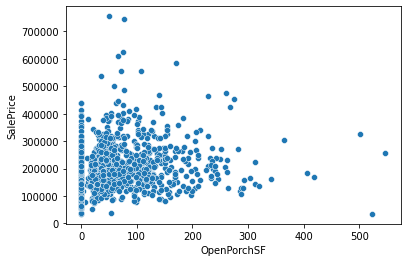

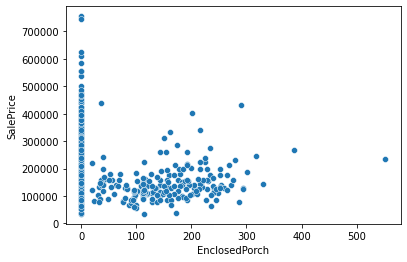

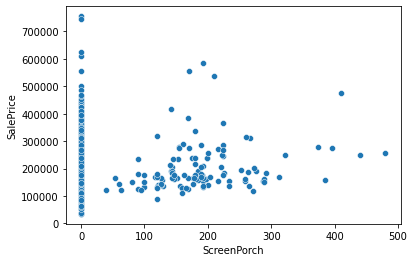

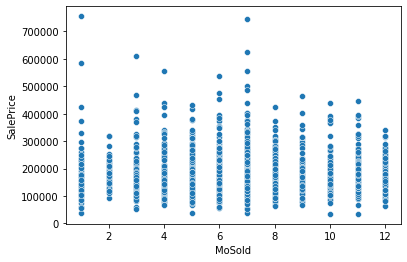

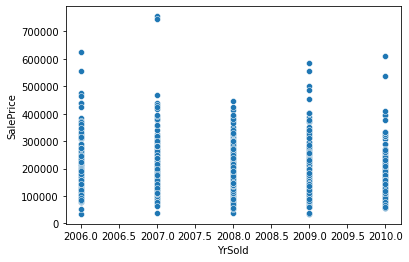

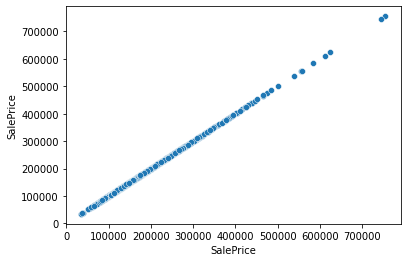

In [25]:
for feature_obj in df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=df_for_learning_no_missing[feature_obj], y=df_for_learning_no_missing['SalePrice'])
    plt.show()

Looking at the graphs above we may see outliers just visually and remove them

In [26]:
# from sklearn.ensemble import IsolationForest
# IsForest = IsolationForest(contamination = 0.03)
# outliers_train = IsForest.fit_predict(df_for_learning_no_missing[get_num_features_for_train(df_for_learning_no_missing)])
# df_for_learning_no_missing = df_for_learning_no_missing.loc[outliers_train==1]

In [27]:
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.HeatingQC != 'Po']
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.GrLivArea < 4500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.SalePrice < 700000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotRmsAbvGrd < 14]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.OpenPorchSF < 500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.WoodDeckSF < 800]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BedroomAbvGr < 8]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFullBath < 3]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.FirstFlrSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.TotalBsmtSF < 4000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.BsmtFinSF1 < 5000]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.MasVnrArea < 1500]
df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotArea < 100000]
#df_for_learning_no_missing = df_for_learning_no_missing[df_for_learning_no_missing.LotFrontage < 200]

As we can also see, some numerical features may be transformed into categorical features, because they have only a short range of values

In [28]:
def numerical_to_object(df_tr, df_test):
    threshold = 30
    numerical_features = get_num_features_for_train(df_tr)
    for feature in numerical_features:
        if len(df_tr[feature].value_counts()) < threshold:
            df_tr[feature] = df_tr[feature].apply(lambda x: str(x))
            df_test[feature] = df_test[feature].apply(lambda x: str(x))
            
# numerical_to_object(df_for_learning_no_missing, df_for_test_no_missing)

## Feature engineering

In [29]:
from scipy.stats import anderson
from scipy.stats import kstest

In [30]:
def make_new_features(data_frame):
    data_frame['OverallQualSquared'] = data_frame['OverallQual'] * data_frame['OverallQual']
    data_frame['GarageYrBltSquared'] = data_frame['GarageYrBlt'] * data_frame['GarageYrBlt']
    data_frame['SecondFlrSFSquared'] = data_frame['SecondFlrSF'] * data_frame['SecondFlrSF']
    data_frame['YearBuiltSquared'] = data_frame['YearBuilt'] * data_frame['YearBuilt']
    return data_frame

In [31]:
# df_for_learning_no_missing = make_new_features(df_for_learning_no_missing)
# df_for_test_no_missing = make_new_features(df_for_test_no_missing)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

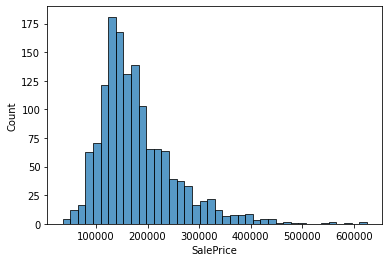

In [32]:
sns.histplot(df_for_learning_no_missing['SalePrice'])

In [33]:
kstest((df_for_learning_no_missing['SalePrice']),cdf = 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

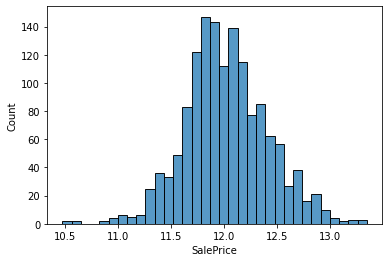

In [34]:
sns.histplot(np.log(df_for_learning_no_missing['SalePrice']))

In [ ]:
df_for_learning_no_missing['SalePrice'] = np.log(df_for_learning_no_missing['SalePrice'])

In [36]:
kstest((df_for_learning_no_missing['SalePrice']),cdf = 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

## Correlation Analysis

In [37]:
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from scipy.stats import pointbiserialr
from scipy.stats import kruskal

In [38]:
def my_kruskal(df, numeric_value_label, obj_value_label):
    grouped_data = df.groupby(obj_value_label)[numeric_value_label].apply(list)
    return kruskal(*grouped_data)

In [39]:
def get_obj_features_among_numeric(df_tr, df_test):
    obj_features = []
    max_features = 10
    numerical_features = get_num_features_for_train(df_tr)
    for feature in numerical_features:
        if len(set(df_tr[feature])) < max_features:
            obj_features.append(feature)
    return obj_features

obj_feats_among_num = get_obj_features_among_numeric(df_for_learning_no_missing, df_for_test_no_missing)

In [40]:
def my_anova(df, numeric_value_label, obj_value_label):
    grouped_data = df.groupby(obj_value_label)[numeric_value_label].apply(list)
    return f_oneway(*grouped_data)

In [41]:
conf_level = 0.05
not_important_obj_methods = []
for feature in list(df_for_learning_no_missing.select_dtypes(include= ['object'])) + obj_feats_among_num:
    anova_result = my_anova(df_for_learning_no_missing, 'SalePrice', feature)
    if anova_result[1] > conf_level:
        not_important_obj_methods.append(feature)
        print("Feature: {}, anova results: {}".format(feature, anova_result))

Feature: LandSlope, anova results: F_onewayResult(statistic=0.9688241040972998, pvalue=0.3797775128017953)
Feature: BsmtHalfBath, anova results: F_onewayResult(statistic=0.20643801396544756, pvalue=0.8135008721632976)
Feature: YrSold, anova results: F_onewayResult(statistic=0.4437263958620035, pvalue=0.777044762695326)


In [42]:
conf_level = 0.05
not_important_obj_methods = []
for feature in list(df_for_learning_no_missing.select_dtypes(include= ['object'])) + obj_feats_among_num:
    kruskal_result = my_kruskal(df_for_learning_no_missing, 'SalePrice', feature)
    if kruskal_result[1] > conf_level:
        not_important_obj_methods.append(feature)
        print("Feature: {}, kruskal_results: {}".format(feature, kruskal_result))

Feature: LandSlope, kruskal_results: KruskalResult(statistic=2.675675497236384, pvalue=0.26241245728804036)
Feature: BsmtHalfBath, kruskal_results: KruskalResult(statistic=0.46281404528836473, pvalue=0.7934164618384556)
Feature: YrSold, kruskal_results: KruskalResult(statistic=1.0932787949803349, pvalue=0.8953371291593718)


In [43]:
df_for_learning_no_missing.drop(columns=not_important_obj_methods, inplace=True)
df_for_test_no_missing.drop(columns=not_important_obj_methods, inplace=True)

In [44]:
def get_binary_columns(df):
    bin_cols = []
    for feature in df.columns:
        number_of_values = set(df[feature])
        if len(number_of_values) == 2:
            bin_cols.append(feature)
    return bin_cols

In [45]:
bin_cols = get_binary_columns(df_for_learning_no_missing)
bin_cols

['CentralAir']

In [46]:
corr_for_SalePrice = {}
non_obj_cols = get_num_features_for_train(df_for_learning_no_missing)
numeric_cols = [i for i in non_obj_cols if i not in bin_cols]
for feature in df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns:
    corr_for_SalePrice[feature] = spearmanr(df_for_learning_no_missing['SalePrice'], 
                                       df_for_learning_no_missing[feature])[0]
corr_for_SalePrice = pd.DataFrame(data = corr_for_SalePrice.values(), index = corr_for_SalePrice.keys(), columns = ['Corr_Value'])

corr_for_SalePrice.sort_values(by = 'Corr_Value', key = lambda x: np.abs(x),ascending = False, inplace = True)
corr_for_SalePrice

,Corr_Value
SalePrice,1.000000
OverallQual,0.810832
GrLivArea,0.727674
GarageCars,0.692629
YearBuilt,0.662223
GarageArea,0.649181
FullBath,0.635720
GarageYrBlt,0.619527
TotalBsmtSF,0.596280
YearRemodAdd,0.575503


In [47]:
threshold = 0.1
less_corr_features = corr_for_SalePrice.index[abs(corr_for_SalePrice["Corr_Value"]) < threshold]
less_corr_features = list(less_corr_features)
less_corr_features

['MoSold', 'BsmtFinSF2', 'Id', 'MSSubClass']

Remove all features only a little bit correlated with the SalePrice column (let it be less than 10%)

In [48]:
df_for_learning_no_missing.drop(less_corr_features, axis = 1, inplace = True)
df_for_test_no_missing.drop(less_corr_features, axis = 1, inplace = True)

 for binary columns:

In [49]:
# corr_for_SalePrice = {}
# for feature in bin_cols:
#     corr_for_SalePrice[feature] = pointbiserialr(df_for_learning_no_missing[feature], df_for_learning_no_missing['SalePrice'],)[0]
# corr_for_SalePrice = pd.DataFrame(data = corr_for_SalePrice.values(), index = corr_for_SalePrice.keys(), columns = ['Corr_Value'])

# corr_for_SalePrice.sort_values(by = 'Corr_Value', key = lambda x: np.abs(x),ascending = False, inplace = True)

# threshold = 0.1
# less_corr_features = corr_for_SalePrice.index[abs(corr_for_SalePrice["Corr_Value"]) < threshold]
# less_corr_features = list(less_corr_features)

# df_for_learning_no_missing.drop(less_corr_features, axis = 1, inplace = True)
# df_for_test_no_missing.drop(less_corr_features, axis = 1, inplace = True)

# less_corr_features

In [50]:
obj_features = df_for_learning_no_missing.select_dtypes(include=['object']).columns
numerical_features = df_for_learning_no_missing.select_dtypes(include=['int64','float64']).columns
binary_features = df_for_learning_no_missing.select_dtypes(include=['bool']).columns

In [51]:
df_for_corr = df_for_learning_no_missing.copy()
LE =LabelEncoder()
for obj_feature in obj_features:
    df_for_corr[obj_feature] = LE.fit_transform(df_for_corr[obj_feature])

Correlation between categorical features

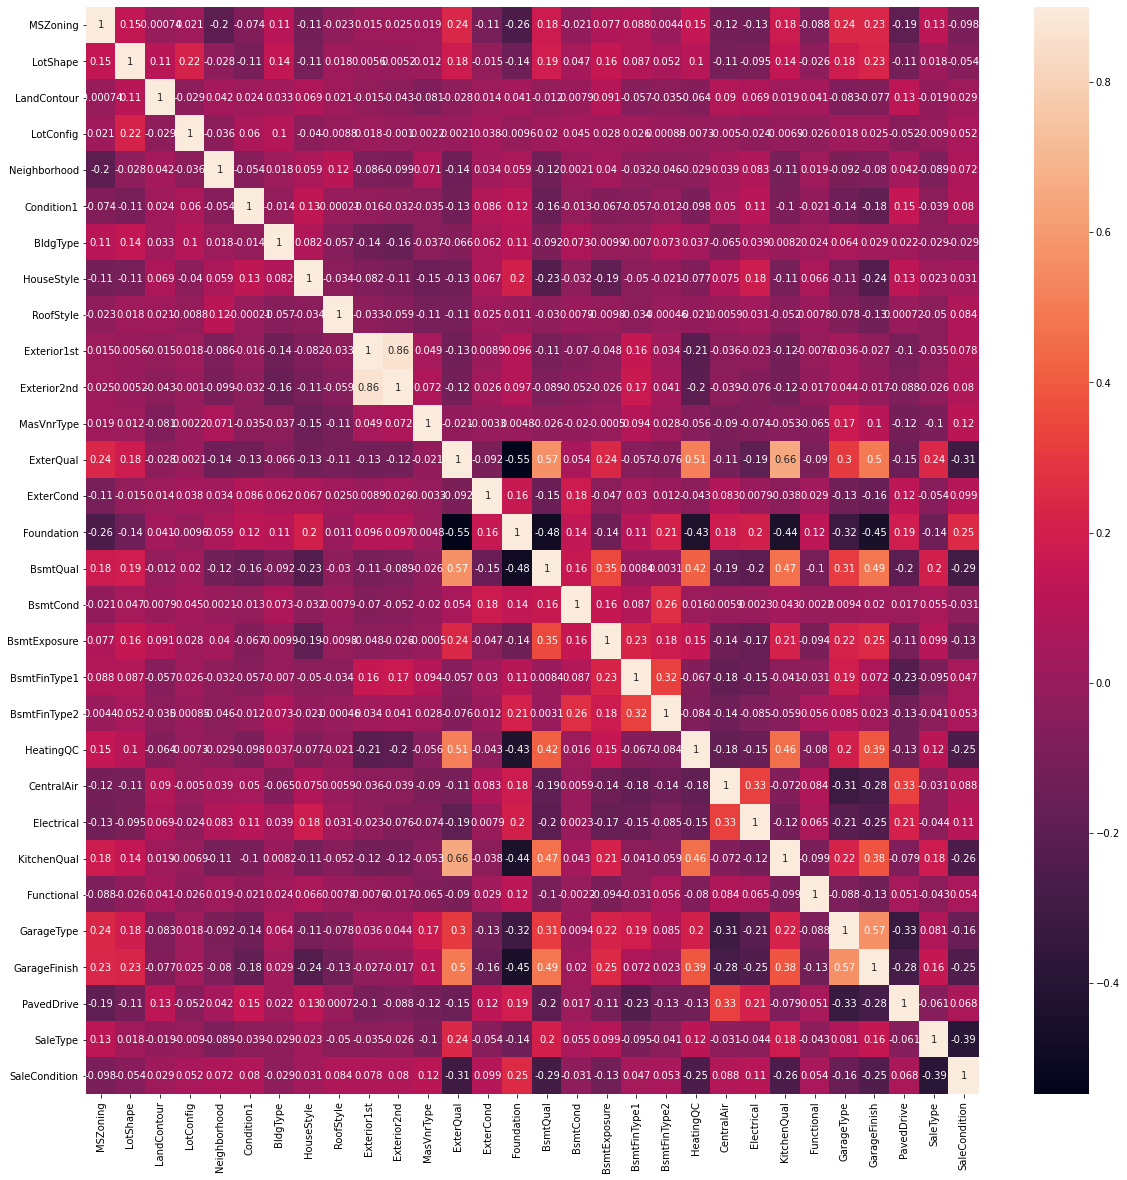

In [52]:
corr_matrix = df_for_corr[obj_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(20,20)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True);

Correlation between numerical features

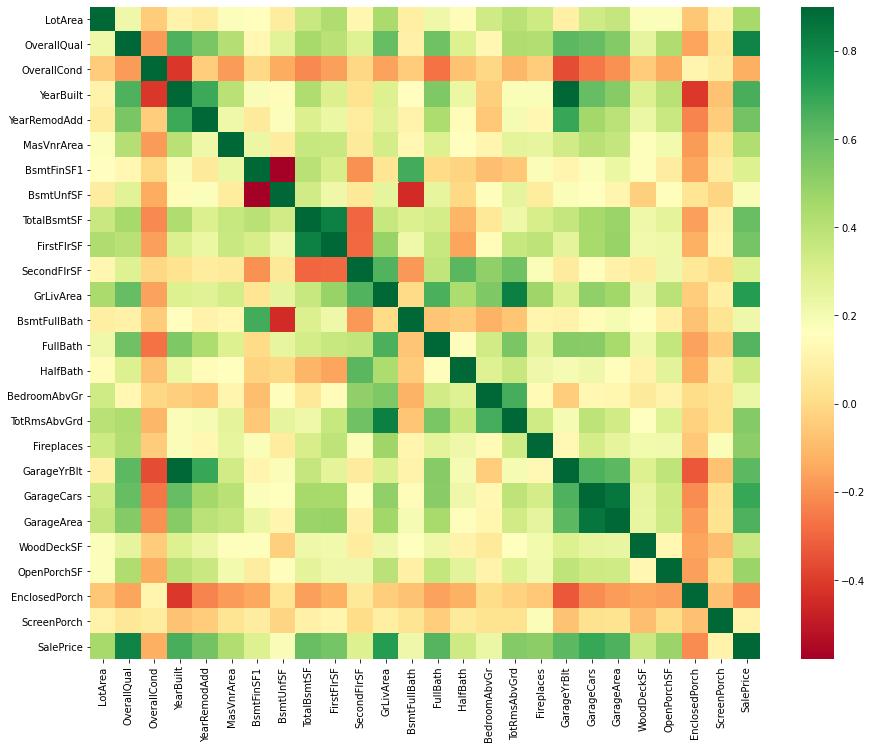

In [53]:
corr_matrix = df_for_corr[numerical_features].corr('spearman')
f, ax1 = plt.subplots(figsize=(15,12)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

<AxesSubplot:xlabel='GarageCars', ylabel='GarageArea'>

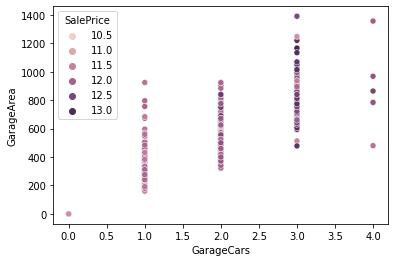

In [54]:
sns.scatterplot(data = df_for_learning_no_missing, x = 'GarageCars', y = 'GarageArea', hue = 'SalePrice')

In [55]:
def remove_correlated_features(df):
    columns_to_drop = ['GarageCars', 'FirstFlrSF', 'GarageYrBlt','GrLivArea']
    #columns_to_drop = ['GarageYrBlt','GarageArea','FirstFlrSF','BedroomAbvGr','BsmtFullBath','ExterQual','HeatingQC','BsmtQual']
    df.drop(columns = columns_to_drop, inplace = True)
    return df

# df_for_learning_no_missing = remove_correlated_features(df_for_learning_no_missing)
# df_for_test_no_missing = remove_correlated_features(df_for_test_no_missing)

In [56]:
df_for_learning_no_missing.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,9989.684540,6.079387,5.576602,1971.200557,1984.770891,101.253482,432.357939,567.392061,1046.403900,1153.532033,...,6.501393,0.604457,1976.448468,1.763928,471.230501,93.305014,45.002089,21.931755,14.840529,12.018453
std,5294.281252,1.364801,1.112668,30.124691,20.649618,173.043089,427.150792,442.436636,410.379336,366.474932,...,1.601175,0.635386,26.246529,0.745239,211.322949,122.800698,61.535526,61.061364,54.620480,0.392536
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,2.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.471950
25%,7500.000000,5.000000,5.000000,1954.000000,1966.750000,0.000000,0.000000,222.500000,793.750000,882.000000,...,5.000000,0.000000,1959.000000,1.000000,326.750000,0.000000,0.000000,0.000000,0.000000,11.773749
50%,9444.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,378.000000,479.500000,989.000000,1081.000000,...,6.000000,1.000000,1978.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,11.994579
75%,11503.000000,7.000000,6.000000,2000.000000,2004.000000,164.250000,700.500000,806.500000,1284.000000,1381.250000,...,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,66.000000,0.000000,0.000000,12.269047
max,70761.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2188.000000,2336.000000,3206.000000,3228.000000,...,12.000000,3.000000,2010.000000,4.000000,1390.000000,736.000000,418.000000,552.000000,440.000000,13.345507


## Some preparations before train

In [57]:
df_for_learning_no_missing.describe

<bound method NDFrame.describe of      MSZoning  LotArea LotShape LandContour LotConfig Neighborhood Condition1  \
0          RL     8450      Reg         Lvl    Inside      CollgCr       Norm   
1          RL     9600      Reg         Lvl       FR2      Veenker      Feedr   
2          RL    11250      IR1         Lvl    Inside      CollgCr       Norm   
3          RL     9550      IR1         Lvl    Corner      Crawfor       Norm   
4          RL    14260      IR1         Lvl       FR2      NoRidge       Norm   
...       ...      ...      ...         ...       ...          ...        ...   
1455       RL     7917      Reg         Lvl    Inside      Gilbert       Norm   
1456       RL    13175      Reg         Lvl    Inside       NWAmes       Norm   
1457       RL     9042      Reg         Lvl    Inside      Crawfor       Norm   
1458       RL     9717      Reg         Lvl    Inside        NAmes       Norm   
1459       RL     9937      Reg         Lvl    Inside      Edwards       No

In [58]:
df_for_learning_no_missing = df_for_learning_no_missing.reset_index(drop = True)
df_for_test_no_missing = df_for_test_no_missing.reset_index(drop = True)

## Data transfromation using StandardScaler, PCA and NonLinearTranformation

In [59]:
def get_StandardScaler(train_df):
    numerical_features = get_num_features_for_train(train_df)
    Scaler = StandardScaler()
    num_data = train_df[numerical_features]
    Scaler = StandardScaler().fit(num_data)
    return Scaler

In [60]:
def get_PCA_transformer(train_df, Scaler):
    numerical_features = get_num_features_for_train(train_df)
    pca = PCA(0.95)
    num_data = train_df[numerical_features]
    num_data = Scaler.transform(num_data)
    pca.fit(num_data)
    return pca

In [61]:
def pca_transform(df, pca_fitted_on_train):
    numerical_features = get_num_features_for_train(df)
    num_data = df[numerical_features]
    principalComponents = pca_fitted_on_train.transform(num_data)
    n_components = principalComponents.shape[1]
    pca_col_names = ["pca_{}".format(i+1) for i in range(n_components)]
    pca_data_frame = pd.DataFrame(data = principalComponents
             , columns = pca_col_names)
    df = df.drop(columns = numerical_features)
    df = pd.concat([df, pca_data_frame], axis = 1)
    return df

In [62]:
def scale_numerical_df(df, Scaler):
    numerical_features = get_num_features_for_train(df)
    #Scaler = RobustScaler()
    df[numerical_features] = Scaler.transform(df[numerical_features])
    return df

In [63]:
def get_isomap_transformer(train_df, std_scaler, pca_transformer):
    numerical_features = get_num_features_for_train(train_df)
    isomap = Isomap(n_components=3)
    num_data = train_df[numerical_features]
    num_data = std_scaler.transform(num_data)
    num_data = pca_transformer.transform(num_data)
    isomap.fit(num_data)
    return isomap

In [64]:
def isomap_transform(df, isomap_transformer):
    numerical_features = get_num_features_for_train(df)
    num_data = df[numerical_features]
    num_data = isomap_transformer.transform(num_data)
    isomap_col_names = ["isomap_{}".format(i+1) for i in range(3)]
    isomap_data_frame = pd.DataFrame(data = num_data
             , columns = isomap_col_names)
    df = df.drop(columns = numerical_features)
    df = pd.concat([df, isomap_data_frame], axis = 1)
    return df

Data Normalization (numerical features)

In [65]:
train_data, val_data, train_value, val_value = train_test_split(df_for_learning_no_missing.drop(columns = "SalePrice"), df_for_learning_no_missing.SalePrice, test_size = 0.2, random_state=2021 )

In [66]:
train_data = remove_nans_custom(train_data)
val_data = remove_nans_custom(val_data)
df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)

In [67]:
train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
train_value.reset_index(drop = True, inplace = True)
val_value.reset_index(drop = True, inplace = True)

In [68]:
# df_for_test_no_missing = remove_nans_custom(df_for_test_no_missing)
# train_data = remove_nans_custom(train_data)
# val_data = remove_nans_custom(val_data)

In [69]:
train_data

,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition
0,RL,27650,IR2,HLS,Inside,NAmes,PosA,1Fam,1Story,7,...,RFn,2,505,Y,0,0,0,0,WD,Normal
1,RL,9600,Reg,Lvl,Inside,NWAmes,PosN,1Fam,1Story,8,...,Fin,2,542,Y,474,120,0,0,WD,Normal
2,RM,6120,Reg,Lvl,Inside,BrkSide,Norm,1Fam,1Story,5,...,Unf,1,450,Y,0,0,112,120,WD,Abnorml
3,RM,11426,Reg,Lvl,Inside,OldTown,Norm,1Fam,1.5Fin,7,...,Unf,2,484,N,280,238,0,0,WD,Normal
4,RL,10007,IR1,Lvl,Inside,NAmes,Norm,1Fam,1Story,5,...,RFn,1,312,Y,0,0,0,0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,RL,11900,Reg,Lvl,Inside,NWAmes,Norm,1Fam,1Story,7,...,Fin,2,544,Y,192,0,0,0,WD,Family
1144,RL,9120,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,6,...,RFn,2,433,Y,0,0,0,288,WD,Normal
1145,RL,13682,IR2,HLS,CulDSac,StoneBr,Norm,1Fam,2Story,10,...,Fin,3,641,Y,192,0,37,0,New,Partial
1146,RM,6000,Reg,Lvl,Inside,BrkSide,Norm,1Fam,1.5Fin,6,...,Unf,2,440,Y,0,0,0,0,WD,Normal


In [70]:
std_scaler = get_StandardScaler(train_data)
pca_transformer = get_PCA_transformer(train_data, std_scaler)
isomap_transformer = get_isomap_transformer(train_data, std_scaler, pca_transformer)

In [71]:
train_data = scale_numerical_df(train_data, std_scaler)
val_data = scale_numerical_df(val_data, std_scaler)
df_for_test_no_missing = scale_numerical_df(df_for_test_no_missing, std_scaler)

In [72]:
# train_data = pca_transform(train_data, pca_transformer)
# val_data = pca_transform(val_data, pca_transformer)
# df_for_test_no_missing = pca_transform(df_for_test_no_missing, pca_transformer)

In [73]:
# train_data = isomap_transform(train_data, isomap_transformer)
# val_data = isomap_transform(val_data, isomap_transformer)
# df_for_test_no_missing = isomap_transform(df_for_test_no_missing, isomap_transformer)

After PCA all numerical components become ortogonal

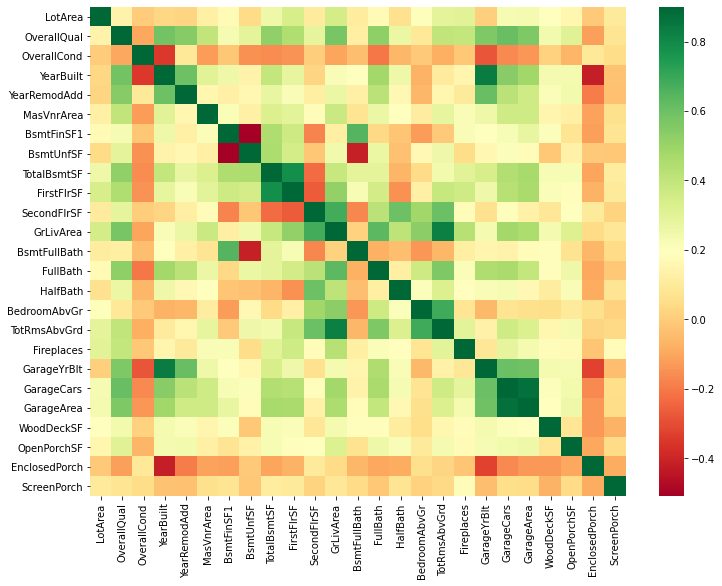

In [74]:
numerical_features  = list(train_data.select_dtypes(include=['int64','float64']).columns)
corr_matrix = train_data[numerical_features].corr('pearson')
f, ax1 = plt.subplots(figsize=(12,9)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, cmap="RdYlGn"); 

So we can see the target variable approximately disributed the same way between train and validation datasets

In [75]:
cat_features = list(df_for_learning_no_missing.select_dtypes(include=['object','bool']).columns)
train_pool = catboost.Pool(
    train_data,
    label=train_value,
    cat_features = cat_features
)
val_pool = catboost.Pool(
    val_data,
    label = val_value,
    cat_features = cat_features
)

In [76]:
catboost_train_dir = 'catboost_train_dir'
!rmdir /S /Q catboost_train_dir
!mkdir catboost_train_dir

In [77]:
regr_model = catboost.CatBoostRegressor(
    # early_stopping_rounds=20,
    random_seed=2021,
    depth = 5,
    od_pval=0.05,
    od_wait=20,
    loss_function='RMSE',
    #learning_rate=0.1,
    iterations = 3000,
    train_dir=catboost_train_dir,
    task_type='GPU',
    # task_type='CPU',
    # devices='0',
    #auto_class_weights='Balanced',
    max_ctr_complexity=4,
    l2_leaf_reg = 1,
    use_best_model=True
)
regr_model.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3856355	test: 0.3943660	best: 0.3943660 (0)	total: 84.2ms	remaining: 4m 12s
1:	learn: 0.3810427	test: 0.3890498	best: 0.3890498 (1)	total: 175ms	remaining: 4m 22s
2:	learn: 0.3766717	test: 0.3839382	best: 0.3839382 (2)	total: 260ms	remaining: 4m 19s
3:	learn: 0.3724917	test: 0.3791135	best: 0.3791135 (3)	total: 347ms	remaining: 4m 20s
4:	learn: 0.3684431	test: 0.3742830	best: 0.3742830 (4)	total: 430ms	remaining: 4m 17s
5:	learn: 0.3642901	test: 0.3694174	best: 0.3694174 (5)	total: 516ms	remaining: 4m 17s
6:	learn: 0.3607777	test: 0.3651697	best: 0.3651697 (6)	total: 596ms	remaining: 4m 14s
7:	learn: 0.3571339	test: 0.3607402	best: 0.3607402 (7)	total: 677ms	remaining: 4m 13s
8:	learn: 0.3537451	test: 0.3567210	best: 0.3567210 (8)	total: 762ms	remaining: 4m 13s
9:	learn: 0.3505498	test: 0.3529500	best: 0.3529500 (9)	total: 853ms	remaining: 4m 14s
10:	learn: 0.3475196	test: 0.3493275	best: 0.3493275 (10)	total: 933ms	remaining: 4m 13s
11:	learn: 0.3447037	test: 0.3458555	bes

95:	learn: 0.2021693	test: 0.2036524	best: 0.2036524 (95)	total: 8.25s	remaining: 4m 9s
96:	learn: 0.2015320	test: 0.2031018	best: 0.2031018 (96)	total: 8.33s	remaining: 4m 9s
97:	learn: 0.2009801	test: 0.2025221	best: 0.2025221 (97)	total: 8.41s	remaining: 4m 9s
98:	learn: 0.2003639	test: 0.2019373	best: 0.2019373 (98)	total: 8.49s	remaining: 4m 8s
99:	learn: 0.1997110	test: 0.2013818	best: 0.2013818 (99)	total: 8.58s	remaining: 4m 8s
100:	learn: 0.1991587	test: 0.2007219	best: 0.2007219 (100)	total: 8.66s	remaining: 4m 8s
101:	learn: 0.1985672	test: 0.2002383	best: 0.2002383 (101)	total: 8.75s	remaining: 4m 8s
102:	learn: 0.1979809	test: 0.1998792	best: 0.1998792 (102)	total: 8.83s	remaining: 4m 8s
103:	learn: 0.1973292	test: 0.1994613	best: 0.1994613 (103)	total: 8.92s	remaining: 4m 8s
104:	learn: 0.1967939	test: 0.1990346	best: 0.1990346 (104)	total: 9.01s	remaining: 4m 8s
105:	learn: 0.1963104	test: 0.1987620	best: 0.1987620 (105)	total: 9.09s	remaining: 4m 8s
106:	learn: 0.195591

limit_output extension: Maximum message size of 10000 exceeded with 10212 characters

Write SalePrice prediction for test values in file

In [78]:
df_to_csv = pd.DataFrame()
df_to_csv['SalePrice'] = regr_model.predict(df_for_test_no_missing)
df_to_csv['SalePrice'] = np.exp(df_to_csv['SalePrice'])
df_to_csv['Id'] = df_test_id
df_to_csv.to_csv('answer.csv', index = False)

## Post-Hoc analysis

In [79]:
features_importance = sorted(
    zip(train_data.columns, regr_model.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)
important_features_cumulative = np.cumsum([feature[1] for feature in features_importance], axis = 0)
features_importance = pd.DataFrame(features_importance)
features_importance.columns = ['Feature','Feature_importance']
features_importance['Cumulative_sum'] = important_features_cumulative
features_importance['CorrWithSalePrice'] = [stats.spearmanr(train_value, train_data[feature])[0]
                                            for feature in features_importance['Feature']]
features_importance

,Feature,Feature_importance,Cumulative_sum,CorrWithSalePrice
0,Neighborhood,24.580808,24.580808,0.163025
1,GrLivArea,19.658735,44.239543,0.723165
2,OverallQual,14.789613,59.029156,0.810802
3,KitchenQual,4.730944,63.760101,-0.568772
4,Exterior2nd,4.046645,67.806746,0.068182
5,TotalBsmtSF,3.003589,70.810335,0.578833
6,OverallCond,2.725545,73.535880,-0.120510
7,GarageArea,2.695344,76.231224,0.631344
8,Exterior1st,2.684237,78.915461,0.055861
9,FirstFlrSF,2.463439,81.378900,0.544882


As we can see many important feautres also have strong correlation with the SalePrice, except NeigborHood (maybe because it is a categorical feature)

In [80]:
shap_info = regr_model.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Processing trees...
128/2165 trees processed	passed time: 18.3ms	remaining time: 292ms
2165/2165 trees processed	passed time: 183ms	remaining time: 0us
Processing documents...
128/1148 documents processed	passed time: 28.2ms	remaining time: 225ms
1148/1148 documents processed	passed time: 246ms	remaining time: 0us


In [81]:
shap_values.shape

(1148, 55)

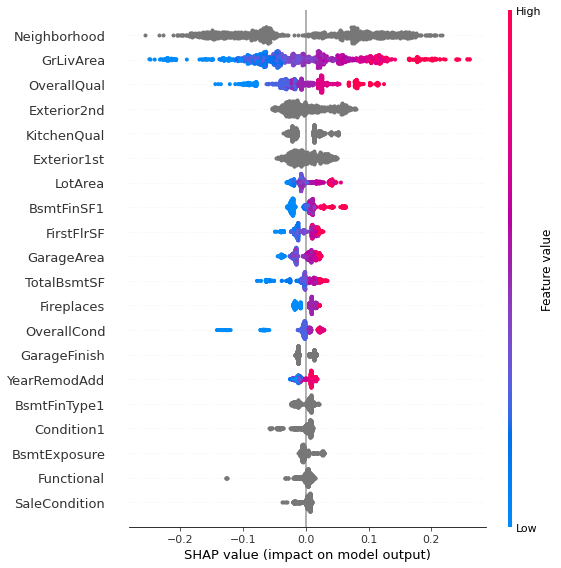

In [82]:
shap.summary_plot(shap_values, train_data)